In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 16)

#FILENAME = 'images/bone247_bse_image1.tif'
FILENAME = 'images/test.jpg'
#FILENAME = 'images/bone312_bse_image6 vs annotated.jpg'
ODIR = '/home/anachronicnomad/Desktop/out_img/'
INDIR = '/home/anachronicnomad/Desktop/2020_03_05/'
FNAME = 'bone247_bse_image1 (2020_03_26 21_49_17 UTC).tif'
#FILENAME = INDIR + FNAME
OFILE = ODIR + FNAME

**Read grayscale image**

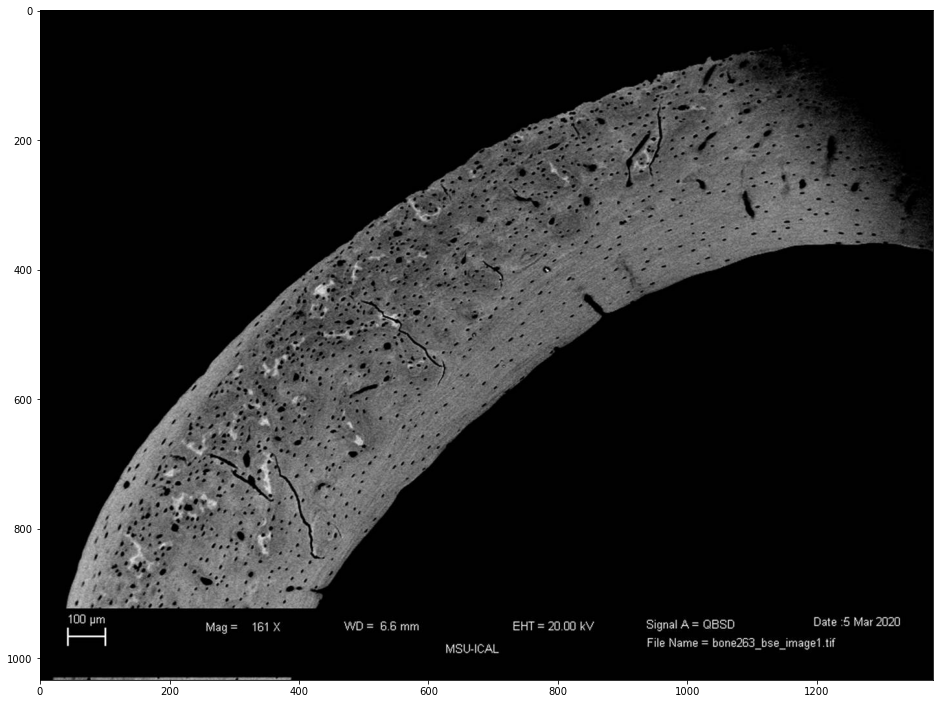

In [2]:
## Read grayscale image, 
img = cv2.imread(FILENAME, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap = 'gray')
plt.show()

**Filter To Drop Shadows, Pre-Process Bone Isolation**

* May want to use additional histogram based approaches here!

In [3]:
# Truncate all image values below threshold
ret,truncd = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)

# Take 5x5 pixel normalized average across image
blur = cv2.GaussianBlur(truncd,(5,5),0)

# Apply binary threshold, Otsu threshold
ret3,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Filter morphology - close gaps
kernel = np.ones((7,7),np.uint8)
closing = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)

**Use Recursive convex hull to identify bone in image**

33


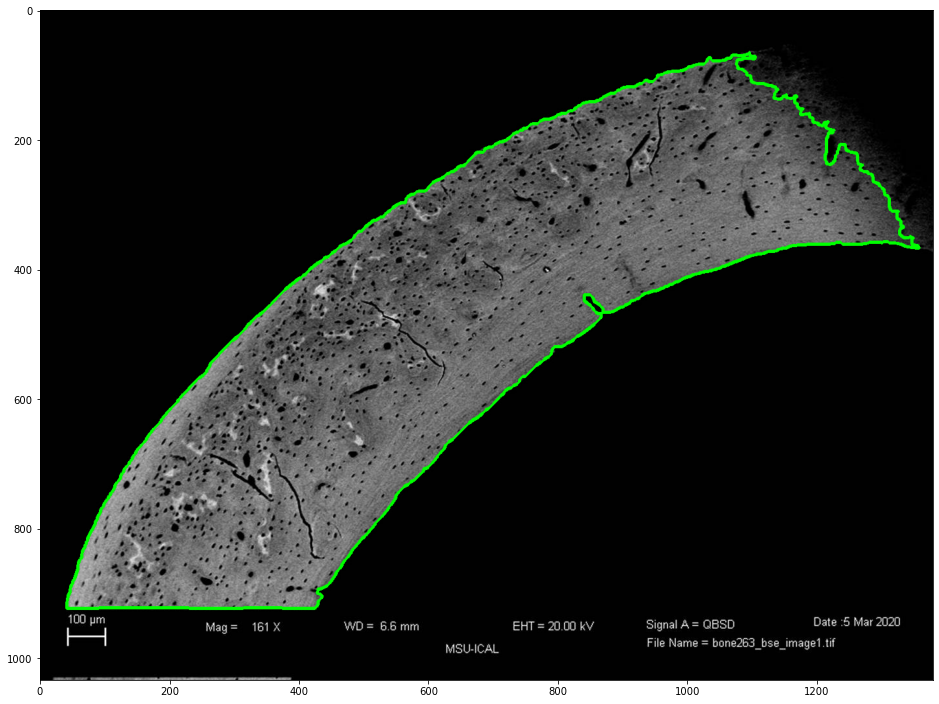

In [4]:
## Contour to find bone region
ret4 = closing.copy()
contours, hierarchy = cv2.findContours(ret4,                                       
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_TC89_L1)


                                       
areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
print(max_index)

color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
tmp2 = color_img.copy() ## Save a copy, `drawContours` will mess with the image

out = cv2.drawContours(color_img, contours, max_index, (0,255,0), 3)
plt.imshow(out)
plt.show()

**Isolate bone**

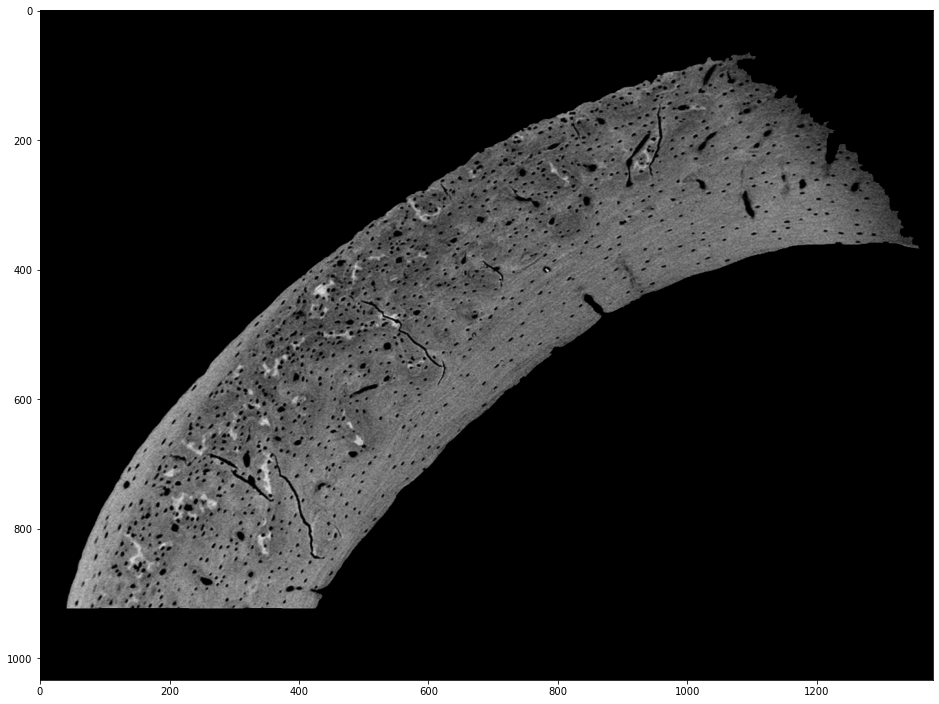

In [5]:
bone = contours[max_index]

fill_color = [0,0,0]
mask_value = 255

stencil = np.zeros(tmp2.shape[:-1]).astype(np.uint8)
cv2.fillPoly(stencil, [bone], mask_value)

sel = (stencil != mask_value)
tmp2[sel] = fill_color

BASE_IMG = cv2.cvtColor(tmp2, cv2.COLOR_BGR2GRAY)
plt.imshow(BASE_IMG, cmap = 'gray')
plt.show()

In [6]:
#cv2.imwrite(OFILE, BASE_IMG)

**Apply Contrast Filtering to highlight contiguous bone/adjust shadows**

Here, we use Contrast-Limited Adaptive Histogram Equalization (CLAHE).  We want tiled grids of roughly 16x16 pixels, so we have to define the number of rows and columns by the ceiling of the width and height of the image over 8. 

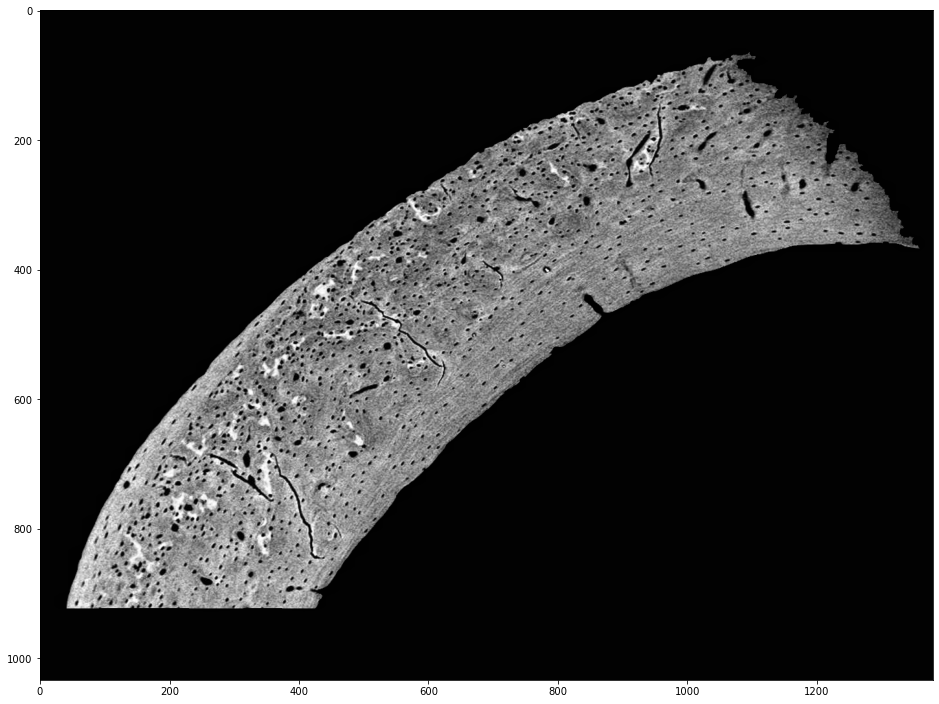

In [7]:
PIX = 16
clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(int(np.ceil(BASE_IMG.shape[0] / PIX)),
                                                        int(np.ceil(BASE_IMG.shape[1] / PIX))))
equalized = clahe.apply(BASE_IMG)

plt.imshow(equalized, cmap = 'gray')
plt.show()

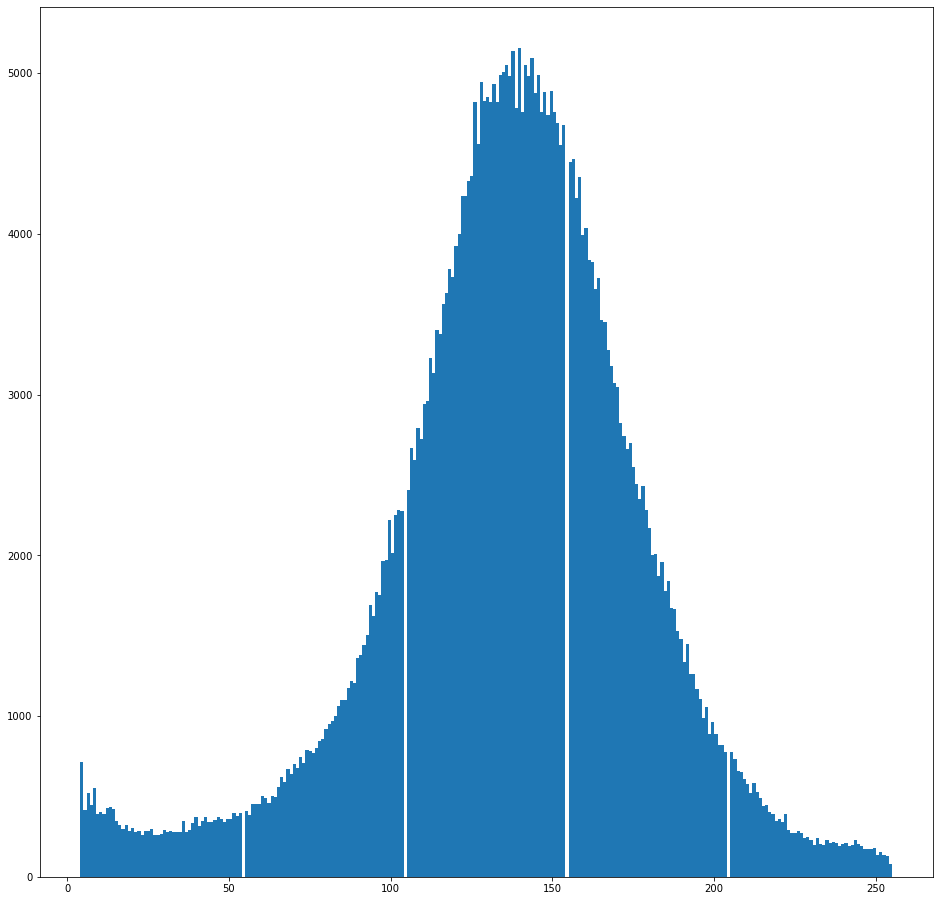

In [8]:
tmp3 = equalized.copy()
tmp3 = tmp3[np.where(tmp3 >= 4)].ravel()
plt.hist(tmp3, bins=256)
plt.show()

**Apply Color Quantization**

We will use 5 colors to represent five categories of mineralized bone or lack thereof we may find in an image.  

We must assume that these five categories will exist in any 

1. Pitch Black `0` - no bone in this pixel
2. Very high mineralization content -- observed visual "chunks" in non-lamellar bone. 
3. Moderate mineralization content -- observed visual lines in lamellar bone.
4. Moderate lack of mineralization content -- observed visual lines in lamellar bone. 
5. Mineralization deprived, relative to (4) -- observed visual chunks in non-lamellar bone. 

We proceed to take the array of grayscale values in the image, and categorize all pixels of the image using $k$-means clustering.  This is done using 10-fold cross-validation and initially random pixels representing grayscale values for each of the 5 categories (centers).

122770135.44819024
[[  3.2746267   3.2775612]
 [124.22968   124.042564 ]
 [196.24167   196.35928  ]
 [155.46657   155.46484  ]
 [ 83.10952    83.46714  ]]


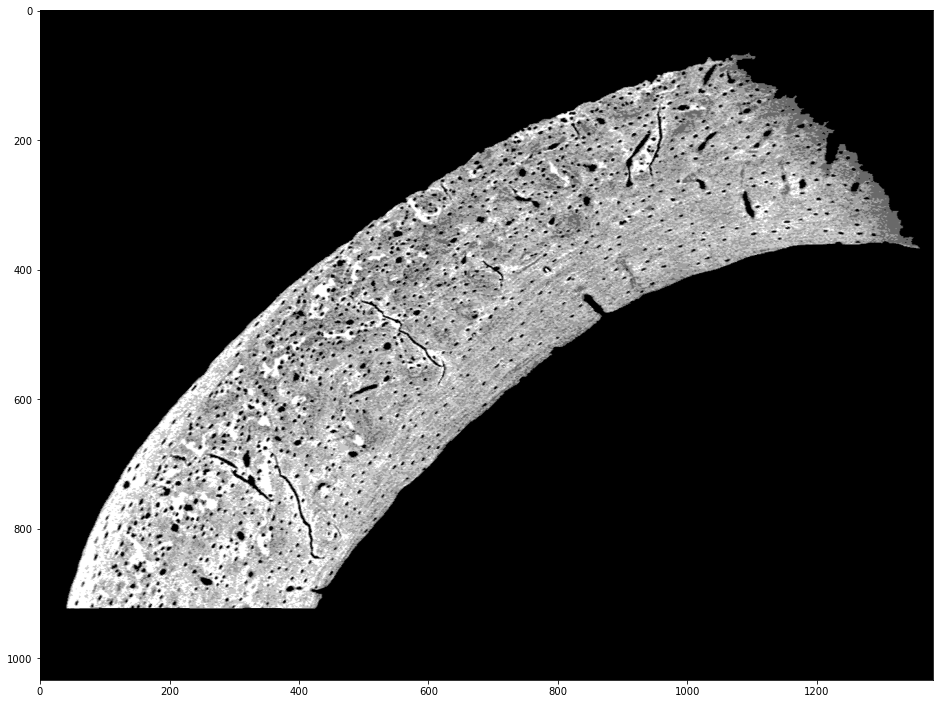

In [13]:
img = equalized.copy()
Z = img.reshape((-1,2))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            4096, 1E-7)
K = 5
ret,label,center=cv2.kmeans(Z,K,None,criteria,20,
                            cv2.KMEANS_RANDOM_CENTERS)
print(ret)
print(center)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(res2, cmap = 'gray')
plt.show()

We can now take the unique grayscale values of the image and sort them.  Positionally, we can now use these grayscale values to retain areas we suspect are nonlamellar via image thresholding.  In this case, we are able to take specific values and potentially trim them out of the original image.  Alternatively, we can use these centroids as truncation setpoints in the equalized histogram, and count proportions of the equalized histogram which are below or above these points.  

In [14]:
tmp1 = res2.copy()
category_grayscale_values = np.sort(np.unique(tmp1.flatten()))
category_grayscale_values

array([  3,  83, 124, 155, 196], dtype=uint8)

For example, we expect pixels in the equalized histogram between `3` and `83` to be potentially mineral definicient pixels.  Meanwhile, values above `196` in this case are clearly highly mineralized areas relative to the rest of the image. 

To illustrate what's happened, let's start "removing" certain classification of mineral density from the image. 

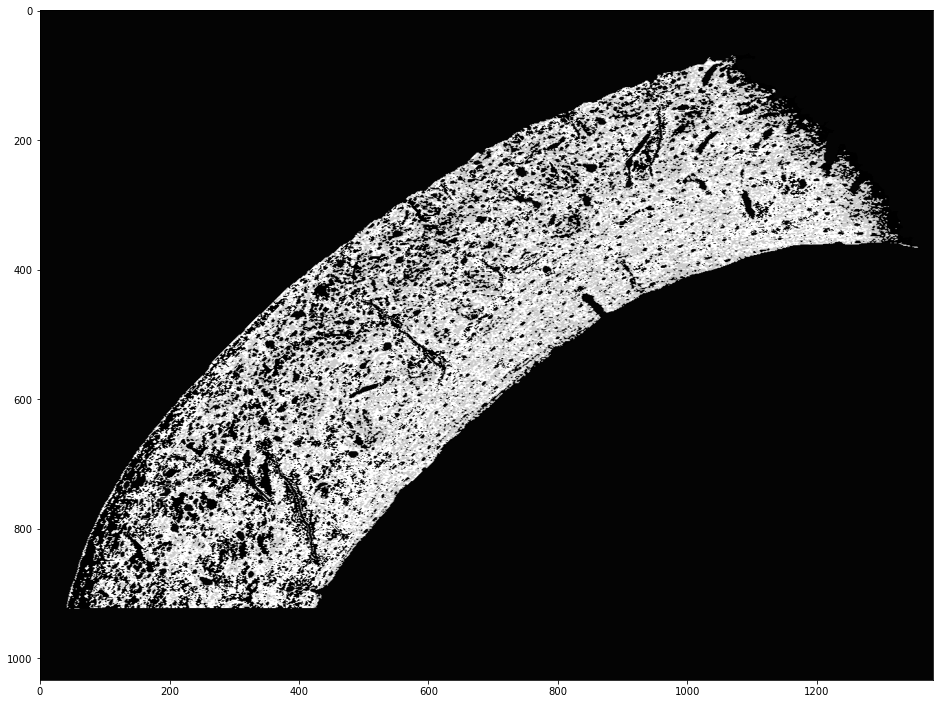

In [11]:
tmp1 = res2.copy()

lam_lo = np.max(category_grayscale_values)
lam_hi = category_grayscale_values[1]
lam_nx = category_grayscale_values[2]

tmp1[np.where(tmp1 == lam_lo)] = [0]
tmp1[np.where(tmp1 == lam_hi)] = [0]
tmp1[np.where(tmp1 == lam_nx)] = [0]

plt.imshow(tmp1, cmap = 'gray')
plt.show()

Now let's try to draw some contours. 

1
[[[-1 -1 -1 -1]]]


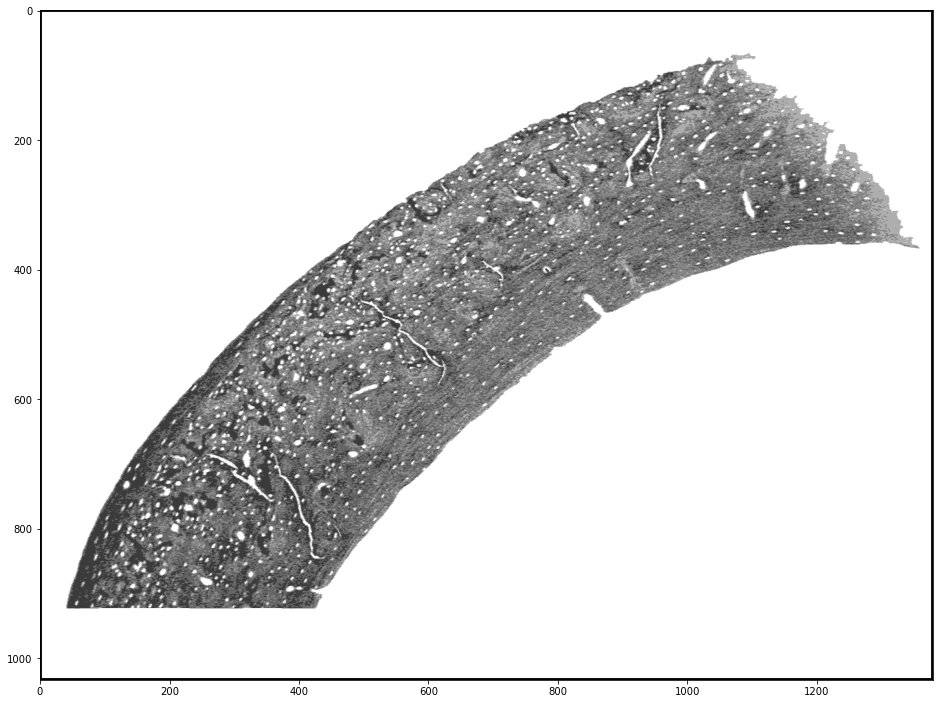

In [15]:
tmp42 = res2.copy()
tmp42 = cv2.bitwise_not(tmp42)
#to_find = cv2.cvtColor(res2, cv2.COLOR_GRAY2BGR)
int_cont, hierarchy = cv2.findContours(tmp42, 
                                       cv2.RETR_TREE, 
                                       cv2.CHAIN_APPROX_SIMPLE)
print(len(int_cont))
print(hierarchy)
out = cv2.drawContours(tmp42, int_cont, -1, (0,255,0), 3)

plt.imshow(tmp42, cmap='gray')
plt.show()